# Working with lists of molecules in RDKit

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

In [2]:
DrawingOptions.bondLineWidth=1.8
DrawingOptions.atomLabelFontSize=14

In cheminformatics, we are rarely interested in performing calculations on a single molecule at a time. Rather, libraries of molecules are the subject of our computations. Depending on the size of these libraries and the limiting steps of our computations, we may want to represent the libraries using different data structures.

For small-ish libraries, it is convenient to create a group of molecules as a python list:

In [3]:
smiles_list = [ 'C', 'CC', 'CCC', 'CCCC', 'CCCCC', 'C1CCCCC1' ]

This is currently just a list of strings:

In [4]:
type(smiles_list[0])

str

We would like to turn it into a list of molecule objects. We can do that by iterating through our list of SMILES strings and turning each into a new molecule using the `Chem.MolFromSmiles` method. We could do that using a for loop, but a more convenient consruct to use in python is called a list comprehension:

In [5]:
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

In [6]:
type(mol_list[0])

rdkit.Chem.rdchem.Mol

We can query a single member of the list:

In [7]:
mol_list[2].GetNumAtoms()

3

Or we can operate on all elements of the list:

In [8]:
[mol.SetProp('_Name', 'C'+str(mol.GetNumAtoms())) for mol in mol_list];

In [9]:
print Chem.MolToMolBlock(mol_list[2])

C3
     RDKit          

  3  2  0  0  0  0  0  0  0  0999 V2000
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
M  END



Now we'd like to take a look at the 2D representations of our complete set of molecules. We use the keyword argument `legends` to send a list of molecule names to be printed alongside the 2D representations. The list comprehension construct that we introduced above is great for performing operations like this.

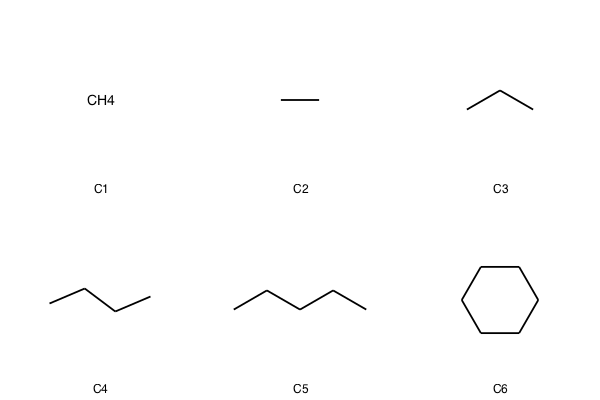

In [10]:
Chem.Draw.MolsToGridImage(mol_list,legends=[mol.GetProp('_Name') for mol in mol_list])

We typically won't be manually writing SMILES strings to create sets of molecules. For sets of any reasonable size, we will usually want to read these in from a file, either in the form of SMILES strings or an SDF file with multiple molecule records.

In [11]:
%%file small_smiles.smi

C methane
CC ethane
CCC propane
CCCC butane
CCCCC pentane
C1CCCCC1 cyclohexane

Overwriting small_smiles.smi


In [12]:
new_mols = AllChem.SmilesMolSupplier('small_smiles.smi', titleLine=False)

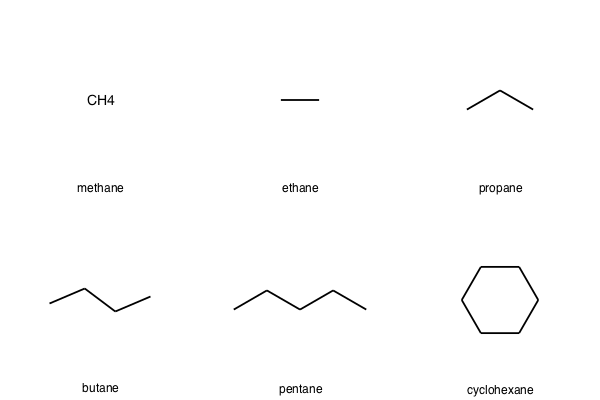

In [13]:
Chem.Draw.MolsToGridImage(new_mols,legends=[mol.GetProp('_Name') for mol in new_mols])

## Filtering lists of molecules by SMARTS pattern

When working with larger lists of molecules it becomes useful to be able to filter them to zoom in on compounds that are of particular interest. Let's load a pickled dataset containing the SMILES strings that resulted from a database search.

In [14]:
import cPickle as pickle

In [15]:
smiles_dict = pickle.load(open('test_15a_200n_hal_chembl19.pkl','rb'))

Here is an example of the data inside the file:

In [16]:
smiles_dict.popitem()

(412673, 'O=C(O)c1cnccc1F')

We can ignore the accession number in the first position and focus on reading all of the SMILES strings (the values in the dictionary) into molecule objects:

In [17]:
selected_mols = [Chem.MolFromSmiles(smi) for smi in smiles_dict.values()]

In [18]:
len(selected_mols)

112

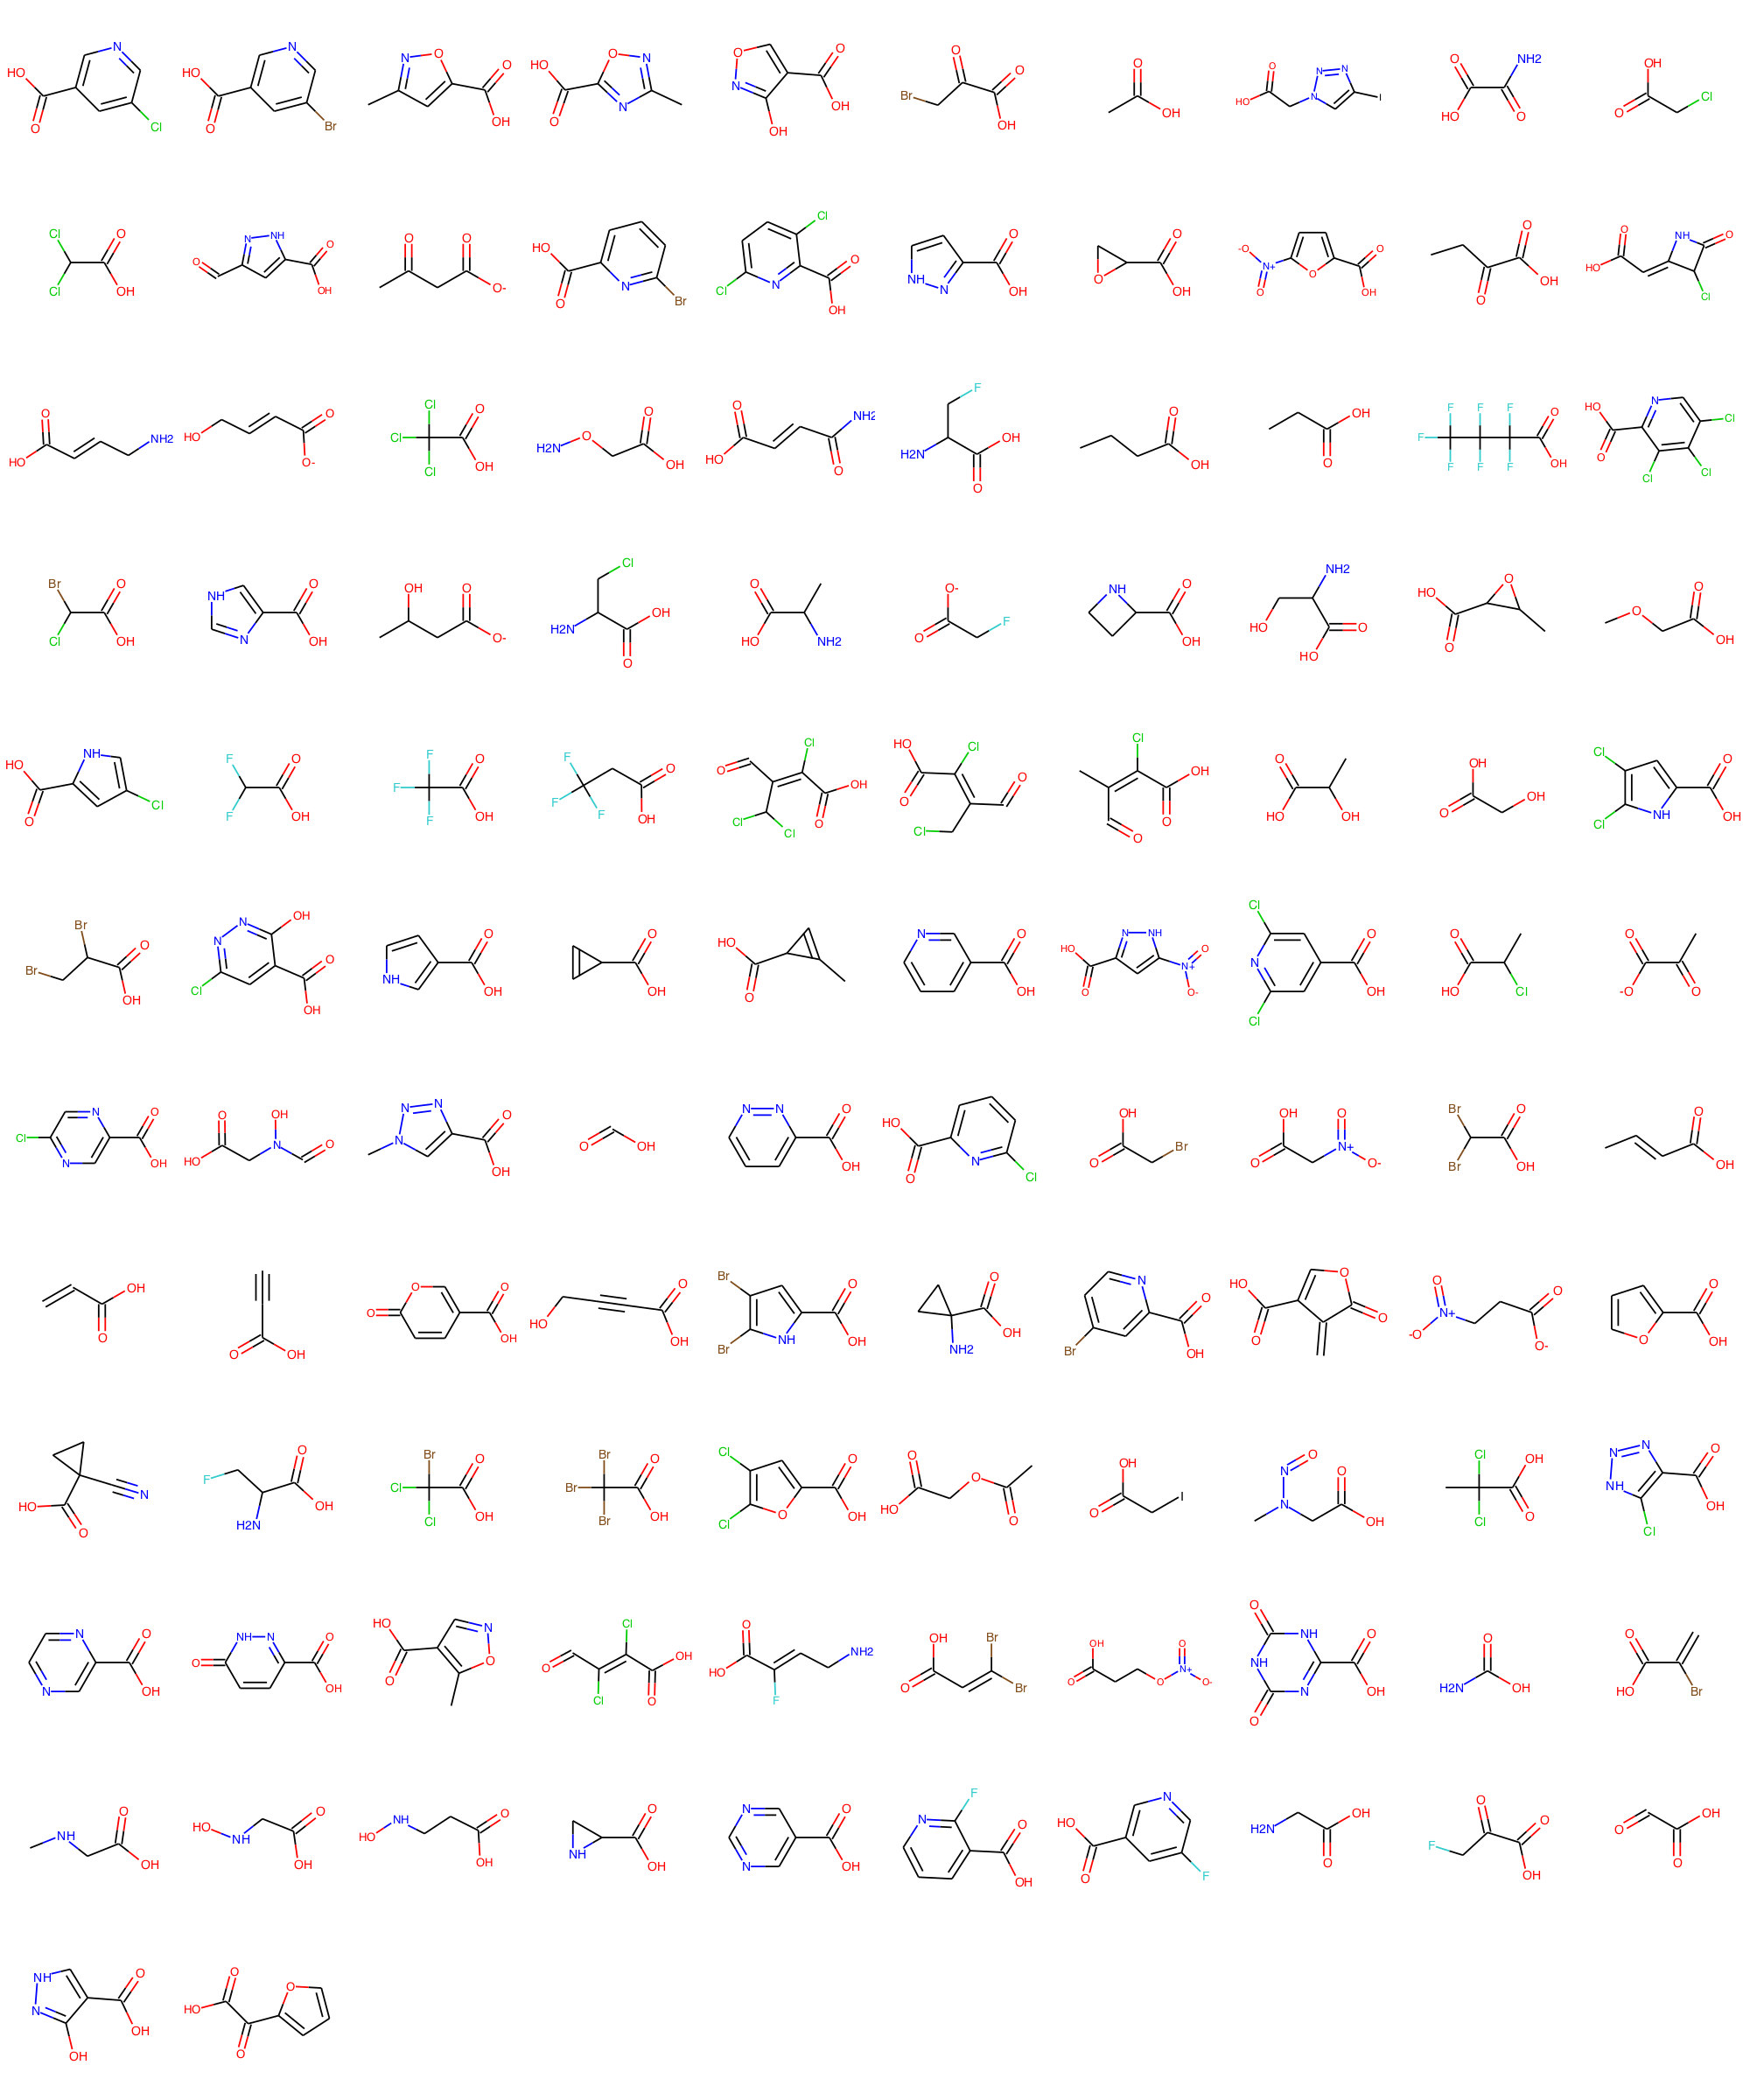

In [20]:
Chem.Draw.MolsToGridImage(selected_mols,molsPerRow=10)

This is an interesting view of the molecules, but with this many it becomes hard to inspect each one. One way to proceed is to identify another chemical pattern that will narrow down the scope of the search. One interesting feature of this list is that some member have three-membered rings. We can pull all of these out of our list by using a SMARTS pattern that recognizes three-membered rings:

In [21]:
tmr = Chem.MolFromSmarts('[r3]')

Each element of the list can be queried to find out whether or not it matches this pattern:

In [22]:
selected_mols[3].HasSubstructMatch(tmr)

False

In [23]:
selected_mols[16].HasSubstructMatch(tmr)

True

A filtered list containing only the molecules matching our query pattern can be assembled by a list comprehension containing an `if` statement:

In [24]:
three_ring_list = [mol for mol in selected_mols if mol.HasSubstructMatch(tmr)]

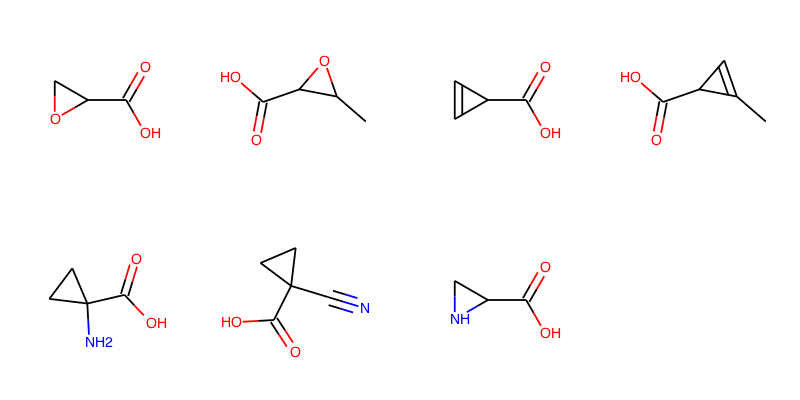

In [72]:
Chem.Draw.MolsToGridImage(three_ring_list,molsPerRow=4)